파일 import

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


DATA_FILE_NAME='test.tsv'


In [88]:
df = pd.read_csv(DATA_FILE_NAME, delimiter='\t')

In [89]:
print(df.tail)

<bound method NDFrame.tail of                                                        댓글  가성비  청결  맛  분위기  친절
0       안국점보단 웨이팅이 덜하긴했는데... 오픈런 안했고 12시쯤 원격줄서기했는데 1시3...    0   0  0    1   1
1       런던베이글뮤지엄 도산점~~🥯 월요일 12시쫌 넘어서 도착했는데… 내앞 대기팀 84팀...    0   0  2    0   0
2       목요일 11시45분 방문했고.. 포장 대기 101팀이 웨이팅중이었어요. 주위에 다른...    0   0  0    1   1
3       월요일에 방문했는데도 웨이팅이 어마어마… 출발하면서 테이블링으로 대기 거는걸 추천합...    0   0  3    0   1
4       평일낮이었지만 금요일이라 그런지 대기가 엄청났어요  매장취식으로 3시간 반정도 후 ...    0   1  1    1   0
...                                                   ...  ...  .. ..  ...  ..
378353                             저렴하고 맛도 좋아요. 원두도 맛납니다.    0   0  0    0   0
378354                                       커피 진짜 맛있어용ㅎㅎ    0   0  0    0   0
378355  홍대에서는 소문난 커피 맛집 이에요  커피 종류는 아메리카노 라떼 카푸치노 딱이렇게...    0   0  0    0   0
378356                                        가성비 갑 라떼맛집!    0   0  0    0   0
378357                                      최고의 가성비 라때 맛집    0   0  0    0   0

[378358 rows x 6 colu

In [90]:
effective_len = len(df.loc[df['가성비'] > 0])
clean_len = len(df.loc[df['청결'] > 0])
tasty_len = len(df.loc[df['맛'] > 0])
vibe_len = len(df.loc[df['분위기'] > 0])
kind_len = len(df.loc[df['친절'] > 0])

[18863, 57710, 165503, 97132, 76582]


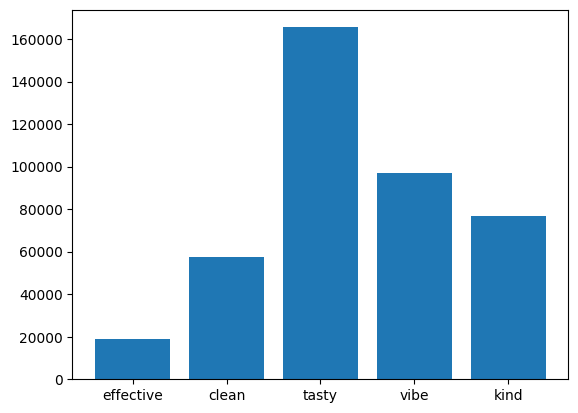

In [91]:
x = np.arange(5)
LABEL_COLUMNS = ['effective', 'clean', 'tasty', 'vibe', 'kind']
values = [effective_len, clean_len, tasty_len, vibe_len, kind_len]


plt.bar(x, values)
plt.xticks(x, LABEL_COLUMNS)

print(values)
plt.show()
# 데이터가 굉장히 불균형 보강 작업이 필요한거 같음

In [92]:
import random
import pickle
import re

wordnet = {}
with open("wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText



########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words


def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	#sentence = get_only_hangul(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not ""]
	num_words = len(words)

	augmented_sentences = []
	num_new_per_technique = int(num_aug/4) + 1

	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	# sr
#	for _ in range(num_new_per_technique):
#		a_words = synonym_replacement(words, n_sr)
#		augmented_sentences.append(' '.join(a_words))

	# ri
	#for _ in range(num_new_per_technique):
#		a_words = random_insertion(words, n_ri)
#		augmented_sentences.append(' '.join(a_words))

	# rs
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(" ".join(a_words))

	# rd
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(" ".join(a_words))

	augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
	random.shuffle(augmented_sentences)

	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	augmented_sentences.append(sentence)

	return augmented_sentences


In [93]:
filterd_df = df[df['맛'] == 0]

In [94]:
#print(df.tail)

from tqdm import tqdm

# list 선언하고 마지막에 dataframe 으로 합치기?

comment_list = []
effective_list = []
clean_list = []
tasty_list = []
vibe_list = []
kind_list = []

for row in tqdm(filterd_df.itertuples()):
    #print(sentence[1]) sentence[1]이 원소에 접근 가능하게 해준다.
    #배열을 뽑고 맛에 해당하는 열이 안나오고 다른게 나오면 복사한다.
    #print(row) # index
    #print(row[1])#댓글
    #print(row[2])#가성비
    #print(row[3])#청결
    #print(row[4])#맛
    #print(row[5])#분위기
    #print(row[6])#친절
    
    if (row[2] or row[3] or row[6]) and not row[4]:
        sentence_list = EDA(row[1])
        for sentence in sentence_list:
            if sentence != row[1]:
                comment_list.append(sentence)
                effective_list.append(row[2])
                clean_list.append(row[3])
                tasty_list.append(row[4])
                vibe_list.append(row[5])
                kind_list.append(row[6])
    




212855it [00:01, 172491.87it/s]


In [95]:
#columns=['댓글','가성비','청결','맛','분위기','친절']
new_df = pd.DataFrame({
                        "댓글" : comment_list, 
                        "가성비" : effective_list, 
                        "청결" : clean_list, 
                        "맛" : tasty_list, 
                        "분위기" : vibe_list, 
                        "친절" : kind_list 
                    })

In [96]:
df = pd.concat([df, new_df])

In [97]:
print(df.tail)

<bound method NDFrame.tail of                                                        댓글  가성비  청결  맛  분위기  친절
0       안국점보단 웨이팅이 덜하긴했는데... 오픈런 안했고 12시쯤 원격줄서기했는데 1시3...    0   0  0    1   1
1       런던베이글뮤지엄 도산점~~🥯 월요일 12시쫌 넘어서 도착했는데… 내앞 대기팀 84팀...    0   0  2    0   0
2       목요일 11시45분 방문했고.. 포장 대기 101팀이 웨이팅중이었어요. 주위에 다른...    0   0  0    1   1
3       월요일에 방문했는데도 웨이팅이 어마어마… 출발하면서 테이블링으로 대기 거는걸 추천합...    0   0  3    0   1
4       평일낮이었지만 금요일이라 그런지 대기가 엄청났어요  매장취식으로 3시간 반정도 후 ...    0   1  1    1   0
...                                                   ...  ...  .. ..  ...  ..
140048                                             👍🏻 좋아요    1   1  0    1   0
140049                                             👍🏻 좋아요    1   1  0    1   0
140050                                           좋아요! 진해서    1   0  0    0   0
140051                                           좋아요! 진해서    1   0  0    0   0
140052                                           좋아요! 진해서    1   0  0    0   0

[518411 rows x 6 colu

In [98]:
effective_len = len(df.loc[df['가성비'] > 0])
clean_len = len(df.loc[df['청결'] > 0])
tasty_len = len(df.loc[df['맛'] > 0])
vibe_len = len(df.loc[df['분위기'] > 0])
kind_len = len(df.loc[df['친절'] > 0])

[42025, 132041, 165503, 159266, 166855]


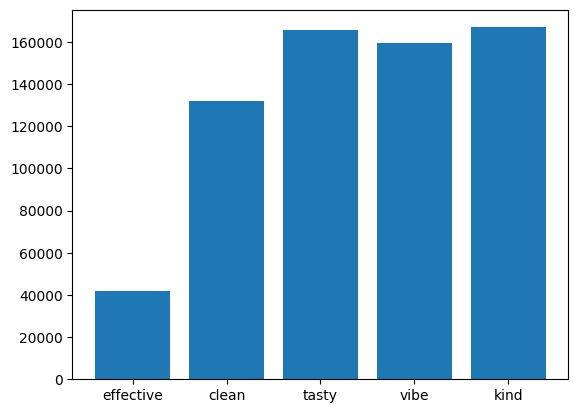

In [99]:
x = np.arange(5)
LABEL_COLUMNS = ['effective', 'clean', 'tasty', 'vibe', 'kind']
values = [effective_len, clean_len, tasty_len, vibe_len, kind_len]


plt.bar(x, values)
plt.xticks(x, LABEL_COLUMNS)

print(values)
plt.show()
# 데이터가 굉장히 불균형 보강 작업이 필요한거 같음

In [100]:
# 추가하고 row 섞자
df = df.sample(frac=1)

In [101]:
print(df.tail)

<bound method NDFrame.tail of                                                        댓글  가성비  청결  맛  분위기  친절
88250                                쌀베이글 쫀떡쫀떡 왕 맛있어요 꺄악ㅜ    0   0  1    0   0
232681                                          밀크티가 맛있어요    0   0  1    0   0
331984             집 근처라 자주 오는데, 비건 글루텐프리 르뱅쿠키 너무 맛있어요🤩🤩     0   1  2    1   1
91553                                       커피 맛있어서 구매했어요    0   0  0    1   1
316152                                     음료종류가 많아서 좋았어요    0   0  0    0   0
...                                                   ...  ...  .. ..  ...  ..
89283   너무 맛있게 딱 가게 내부도 직원분들도 정말 이쁘고 푸릇푸릇해서 친절하셔서 즐겁게 ...    0   1  0    1   1
270923                                               좋아요     0   0  1    2   0
193320                                친절하고 공간도 커피도 좋았어요❤️    0   0  0    0   0
53521                         오리지널로 먹었는데 짜지 않고 맛있어요😆 야들야들    1   0  0    0   1
271206  다시마끼 산도 소스가 독특하고 타마고도 간이 잘 되어있어서 너무 맛있습니다! 몽실타...    1   0  4    0   0

[518411 rows x 6 colu

In [102]:
df.to_csv('enhanced.tsv', index=False, header=True, sep="\t")